In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision
from PIL import Image
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import natsort
from natsort import natsorted
import os

#batch_size = 20
batch_size = 128
num_iters = 31000 #previous 200000
input_dim = 28*28   # num_features = 784
num_hidden = 70 # num of hidden nodes
output_dim = 10

learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class CustomDatasetFromImages(Dataset):
    def __init__(self, csv_path,main_dir):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.to_tensor = transforms.Compose([transforms.Resize(28),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.5,), (0.5,))])

        self.data_info = pd.read_csv(csv_path, header=None)

        self.image_arr = np.asarray(self.data_info.iloc[:, 0])

        self.label_arr = np.asarray(self.data_info.iloc[:, 1])

        self.main_dir = main_dir
        
        all_imgs = os.listdir(main_dir)
        self.total_imgs=all_imgs


    def __getitem__(self, index):
    
            
        single_image_name = self.image_arr[index]
   
       
       # direc=('/content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a/')
        img_loc = os.path.join(self.main_dir, self.total_imgs[index])

        image = Image.open(img_loc).convert('L')
        tensor_image = self.to_tensor(image)
        faltu=[]
        single_image_name = self.image_arr[index]
        single_image_label = self.label_arr[index]
      
        return (tensor_image, single_image_label)

    def __len__(self):
        return len(self.total_imgs)


pathTrain='C:/Users/User/Soft Computing/Assignment 2/Dataset/Dataset A/training-a/Training/'
train_dataset = CustomDatasetFromImages('training-a-modified.csv',pathTrain)


pathTest='C:/Users/User/Soft Computing/Assignment 2/Dataset/Dataset A/training-a/Testing/'
test_dataset = CustomDatasetFromImages('training-a-modified.csv',pathTest)
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 


class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        ### 1st hidden layer: 784 --> 680
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()   

        ### Output layer: 680 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)   
    
    def forward(self, x):
        ## 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
    
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
#criterion =nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
       
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in (test_loader):
               
                images = images.view(-1, 28*28).to(device)
               
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)
    
                # Total correct predictions
                if torch.cuda.is_available():
                
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            iteration_loss.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.276808500289917. Accuracy: 10.276579548337985
Iteration: 1000. Loss: 2.237318277359009. Accuracy: 9.363105810707943
Iteration: 1500. Loss: 2.1996352672576904. Accuracy: 9.286982999238772
Iteration: 2000. Loss: 2.093855142593384. Accuracy: 9.41385435168739
Iteration: 2500. Loss: 2.0398683547973633. Accuracy: 9.312357269728496
Iteration: 3000. Loss: 1.9133166074752808. Accuracy: 9.109363105810708
Iteration: 3500. Loss: 1.8391356468200684. Accuracy: 9.210860187769601
Iteration: 4000. Loss: 1.5872620344161987. Accuracy: 8.804871859934027
Iteration: 4500. Loss: 1.643573522567749. Accuracy: 8.880994671403197
Iteration: 5000. Loss: 1.6199461221694946. Accuracy: 9.134737376300432
Iteration: 5500. Loss: 1.507321834564209. Accuracy: 9.160111646790154
Iteration: 6000. Loss: 1.3743032217025757. Accuracy: 9.312357269728496
Iteration: 6500. Loss: 1.426017165184021. Accuracy: 8.652626236995687
Iteration: 7000. Loss: 1.256545066833496. Accuracy: 8.60187769601624
Iteration: 7500

[2.276808500289917, 2.237318277359009, 2.1996352672576904, 2.093855142593384, 2.0398683547973633, 1.9133166074752808, 1.8391356468200684, 1.5872620344161987, 1.643573522567749, 1.6199461221694946, 1.507321834564209, 1.3743032217025757, 1.426017165184021, 1.256545066833496, 1.2204209566116333, 1.283172369003296, 1.2693873643875122, 1.520520567893982, 1.6129255294799805, 1.2155570983886719, 1.1916966438293457, 1.4302313327789307, 1.146408200263977, 1.1605076789855957, 1.198740839958191, 1.0481783151626587, 1.0358108282089233, 0.9895211458206177, 1.3527371883392334, 1.1290531158447266, 0.9539531469345093, 1.134680986404419, 1.0101947784423828, 0.9822243452072144, 0.9567927122116089, 1.2095659971237183, 0.9900782108306885, 0.929918110370636, 1.1136019229888916, 0.9187333583831787, 0.9782543182373047, 0.7951606512069702, 0.7980320453643799, 0.6387110948562622, 0.8849307894706726, 0.8458981513977051, 0.8283844590187073, 0.6823945641517639, 0.8296590447425842, 0.7426315546035767, 1.1236596107

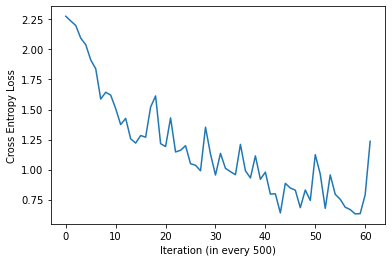

In [4]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.savefig("C:/Users/User/Soft Computing/Assignment 2/Dataset/Dataset A/lossvsiterationcnn.png")
plt.show()


In [5]:
root_path = 'C:/Users/User/Soft Computing/Assignment 2'
save_model = True

if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), root_path + 'Assignment2_cnn.pkl') 

load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Assignment2_cnn.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded
